Environment: This script should be run with the `python_scvi_environment` environment using the devcontainer `docker_python_scvi`

In [1]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from scipy.stats import spearmanr
from scvi.data import cortex, smfish
from scvi.external import GIMVI
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import KDTree
from tqdm.notebook import tqdm

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
train_size = 1

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [3]:
data_path = "../../data"

In [4]:
file = os.path.join(data_path, 'segmentations', 'kt56', 'adatas', 'preprocessed_and_filtered_02.h5ad')
spatial_data= sc.read(file)

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
seq_file = os.path.join(data_path, "DC3000_alone.h5ad")
seq_data = sc.read(seq_file)


/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
intersection = []
non_intersecting = []
for k in spatial_data.var_names:
    if k in seq_data.var_names:
        intersection.append(k)
    else:
        non_intersecting.append(k)

In [7]:
# only use genes in both datasets
seq_data = seq_data[:, intersection].copy()
spatial_data = spatial_data[:, intersection].copy()

In [8]:
seq_gene_names = seq_data.var_names
n_genes = seq_data.n_vars
n_train_genes = int(n_genes * train_size)

# randomly select training_genes

rand_train_genes = spatial_data.var.index.values[:498]
rand_test_genes = spatial_data.var.index.values[498:]

# spatial_data_partial has a subset of the genes to train on
#spatial_data_partial = spatial_data[:, rand_train_genes].copy()
spatial_data_partial = spatial_data.copy()

spatial_data_partial.obs['batch'] = 'spatial'
# remove cells with no counts
sc.pp.filter_cells(spatial_data, min_counts=1)
sc.pp.filter_cells(seq_data, min_counts=1)

# setup_anndata for spatial and sequencing data
GIMVI.setup_anndata(spatial_data_partial, labels_key='batch')
GIMVI.setup_anndata(seq_data, labels_key='SCT_snn_res.1')

# spatial_data should use the same cells as our training data
# cells may have been removed by scanpy.pp.filter_cells()
#spatial_data = spatial_data[spatial_data_partial.obs_names]

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDa

In [9]:
spatial_data_partial.X = spatial_data_partial.layers['counts']

In [10]:
seq_data.X = seq_data.layers['counts']

In [11]:
# create our model
model = GIMVI(seq_data, spatial_data_partial, n_latent = 10)

# train for 200 epochs
model.train(200)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [08:36<00:00,  2.21s/it, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [08:36<00:00,  2.58s/it, v_num=1]


In [12]:
# get the latent representations for the sequencing and spatial data
latent_seq, latent_spatial = model.get_latent_representation()

# concatenate to one latent representation
latent_representation = np.concatenate([latent_seq, latent_spatial])
latent_adata = anndata.AnnData(latent_representation)

# labels which cells were from the sequencing dataset and which were from the spatial dataset
latent_labels = (["seq"] * latent_seq.shape[0]) + (
    ["spatial"] * latent_spatial.shape[0]
)
latent_adata.obs["labels"] = latent_labels

# compute umap
sc.pp.neighbors(latent_adata, use_rep="X")
sc.tl.umap(latent_adata)



In [13]:
# save umap representations to original seq and spatial_datasets
seq_data.obsm["X_umap_gimvi"] = latent_adata.obsm["X_umap"][: seq_data.shape[0]]
spatial_data.obsm["X_umap_gimvi"] = latent_adata.obsm["X_umap"][seq_data.shape[0] :]

In [14]:
seq_data.obs['modality'] = 'seq'
spatial_data.obs['modality'] = 'spatial'

/tmp/ipykernel_3340708/4181862233.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return x[ind], y[ind], z[ind]


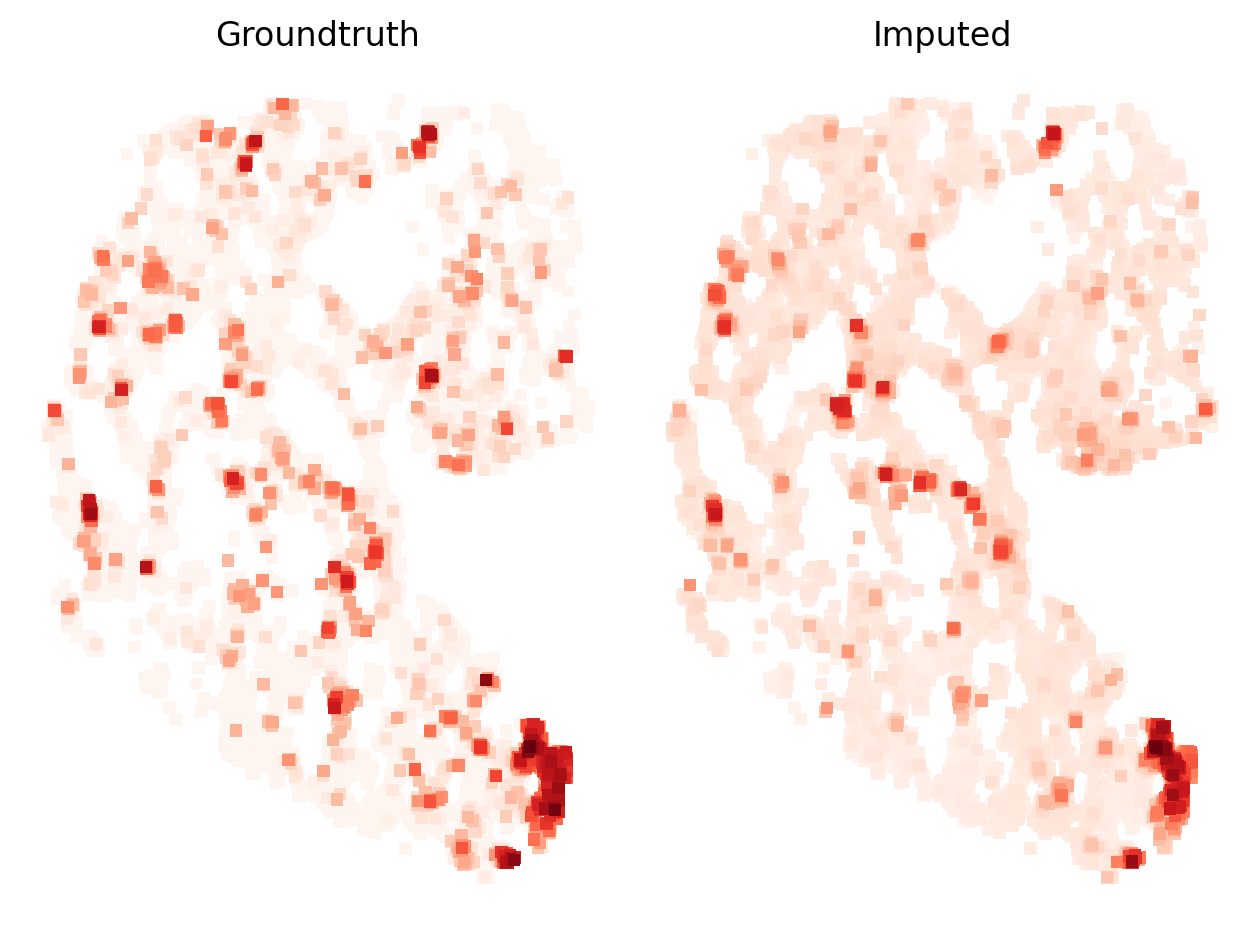

In [15]:
# utility function for plotting spatial genes
def plot_gene_spatial(model, data_spatial, gene):
    data_seq = model.adatas[0]
    data_fish = data_spatial

    fig, (ax_gt, ax) = plt.subplots(1, 2)

    if type(gene) == str:
        gene_id = list(data_seq.var_names).index(gene)
    else:
        gene_id = gene

    x_coord = data_fish.obs["x"]
    y_coord = data_fish.obs["y"]

    def order_by_strenght(x, y, z):
        ind = np.argsort(z)
        return x[ind], y[ind], z[ind]

    s = 20

    def transform(data):
        return np.log(1 + 100 * data)

    # Plot groundtruth
    x, y, z = order_by_strenght(
        x_coord, y_coord, data_fish.X[:, gene_id] / (data_fish.X.sum(axis=1) + 1)
    )
    ax_gt.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax_gt.set_title("Groundtruth")
    ax_gt.axis("off")

    _, imputed = model.get_imputed_values(normalized=True)
    x, y, z = order_by_strenght(x_coord, y_coord, imputed[:, gene_id])
    ax.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax.set_title("Imputed")
    ax.axis("off")
    plt.tight_layout()
    plt.show()


plot_gene_spatial(model, spatial_data, 'ALD1')

In [16]:
seq_latent = model.get_latent_representation()[0]
seq_data.obsm['X_gimvi'] = seq_latent
spatial_data.obsm['X_gimvi'] = model.get_latent_representation()[1]

In [17]:
sc.pp.neighbors(latent_adata, use_rep="X", n_neighbors=30)
sc.tl.umap(latent_adata, min_dist=0.1)

In [18]:
# save umap representations to original seq and spatial_datasets
seq_data.obsm["X_umap_gimvi"] = latent_adata.obsm["X_umap"][: seq_data.shape[0]]
spatial_data.obsm["X_umap_gimvi"] = latent_adata.obsm["X_umap"][seq_data.shape[0] :]

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


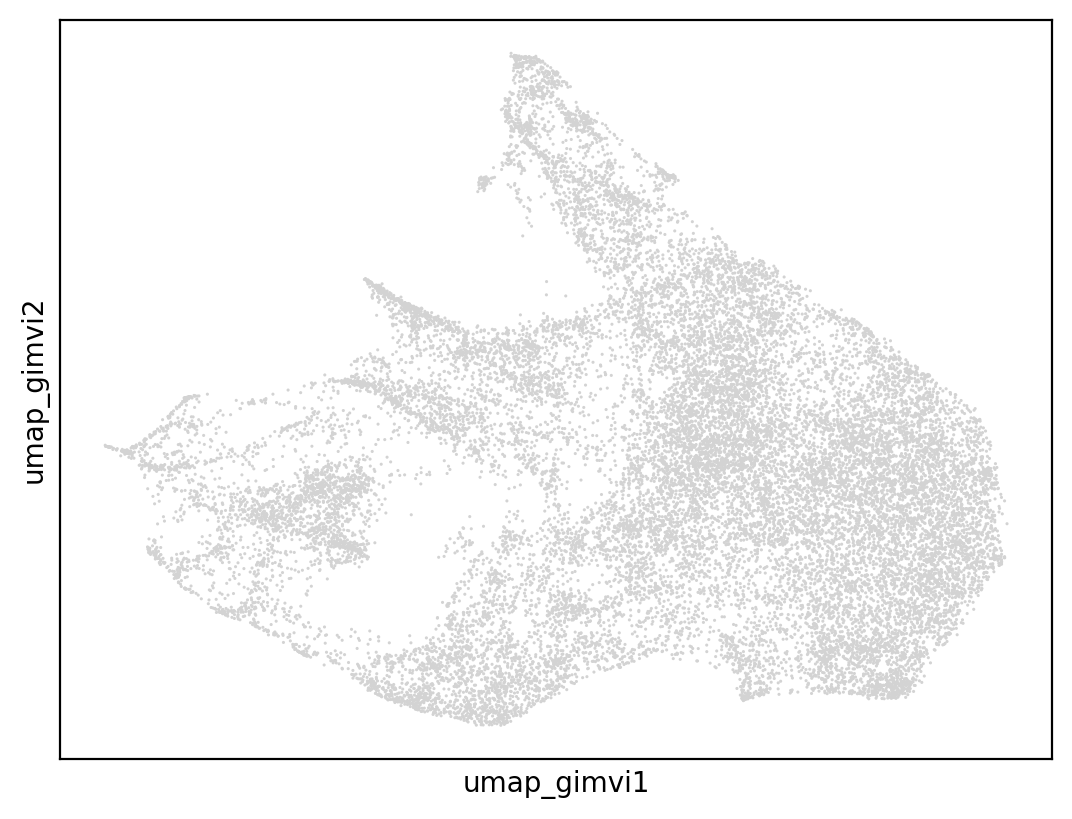

In [19]:
sc.pl.embedding(spatial_data, basis='umap_gimvi')

In [20]:


# Assuming your original AnnData object is named 'adata'
adata = latent_adata.copy()

# Step 1: Filter spatial and seq cells
spatial_cells = adata[adata.obs['labels'] == 'spatial'].copy()
seq_cells = adata[adata.obs['labels'] == 'seq'].copy()
seq_data_copy = seq_data.copy()

# Step 2: Create KD tree for seq cells
seq_gimvi = seq_data.obsm['X_gimvi']
kdtree = KDTree(seq_gimvi)

# Step 3: Find nearest seq cells for each seq
n_neighbors = 30  # Specify the number of nearest neighbors
distances, indices = kdtree.query(spatial_data.obsm['X_gimvi'], k=n_neighbors)

# Step 4: Average gene expression for spatial cells
averaged_expression = np.zeros((spatial_cells.n_obs, 1))

for i in tqdm(range(spatial_cells.n_obs)):
    seq_neighbors_indices = indices[i]
    seq_neighbors_expression = seq_data_copy.obs['pseudotime'].values[seq_neighbors_indices]
    
    averaged_expression[i] = np.mean(seq_neighbors_expression, axis=0)


  0%|          | 0/24090 [00:00<?, ?it/s]

In [21]:
spatial_data.obs['pseudotime'] = averaged_expression.flatten()

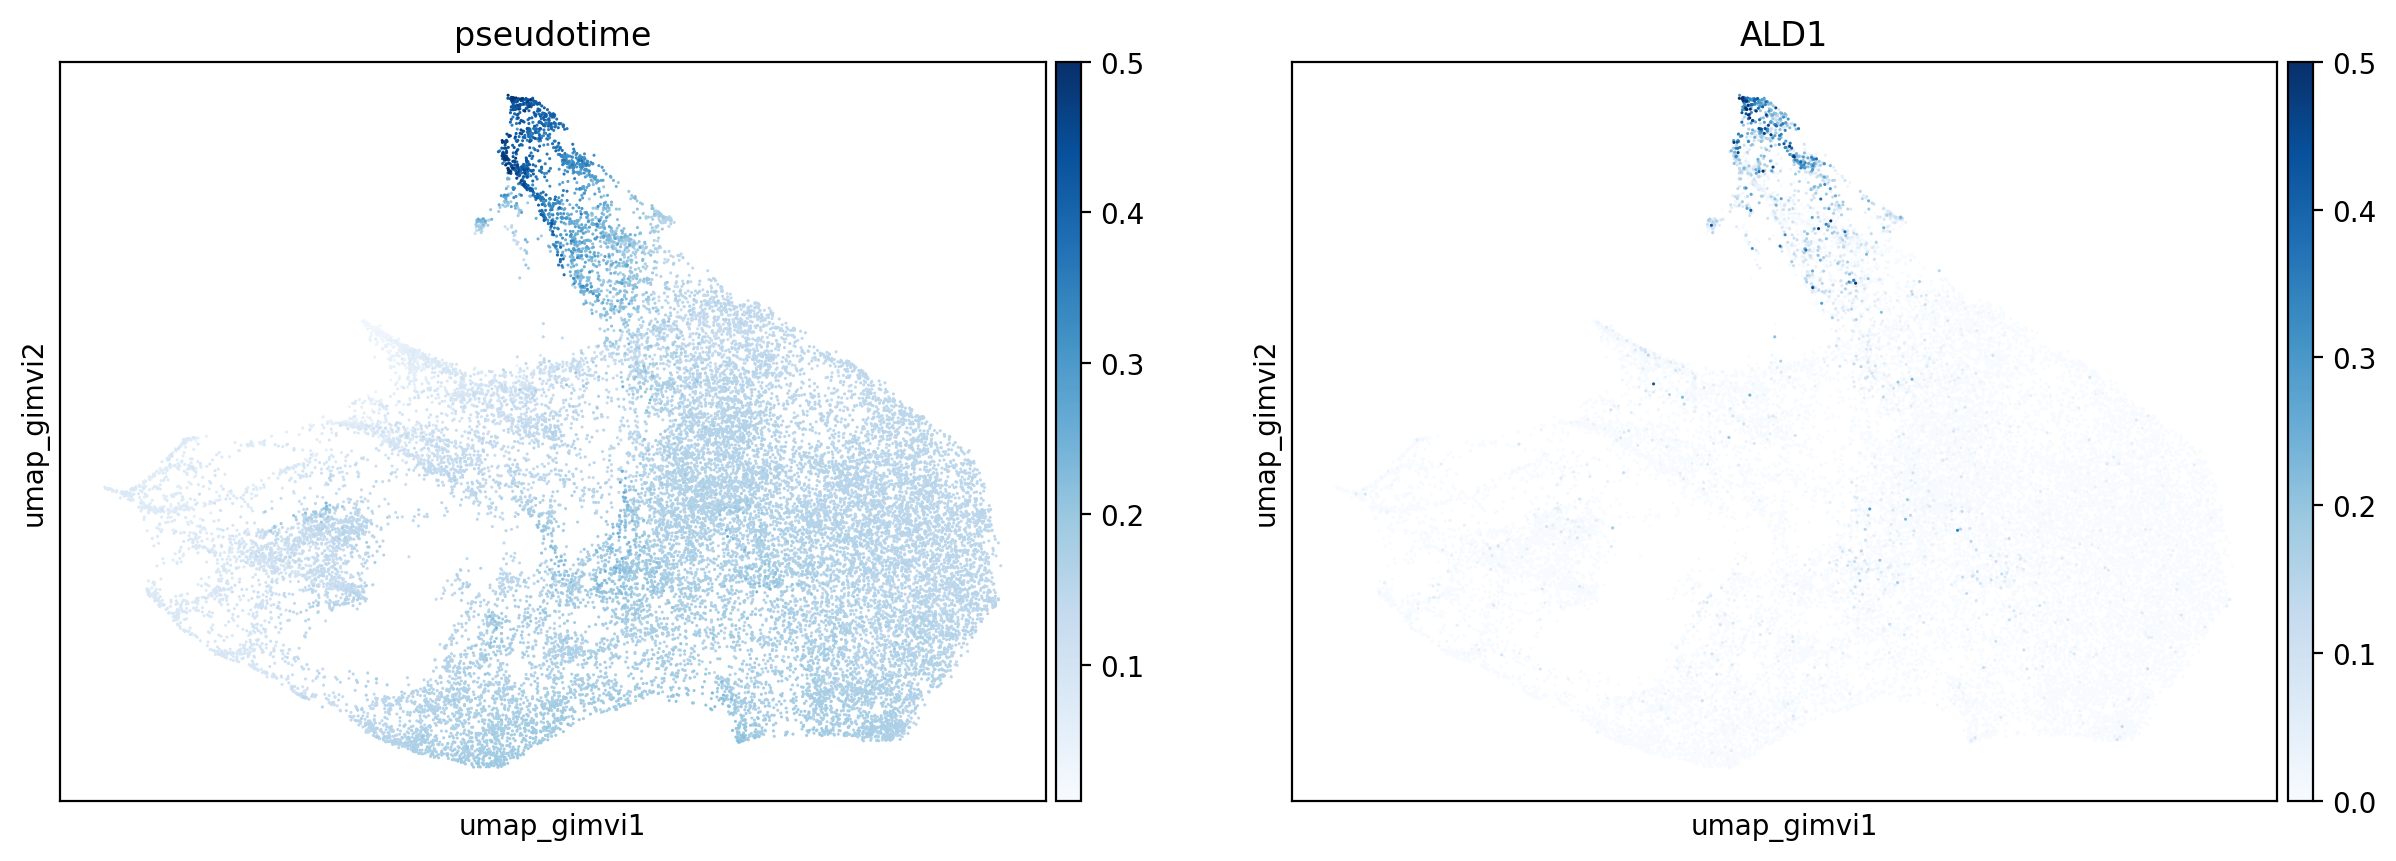

In [22]:
sc.pl.embedding(spatial_data, basis='umap_gimvi',color=['pseudotime', 'ALD1'], vmax=0.5, cmap='Blues')

In [23]:
spatial_data.obsm['X_spatial'] = spatial_data.obs[['x', 'y']].values

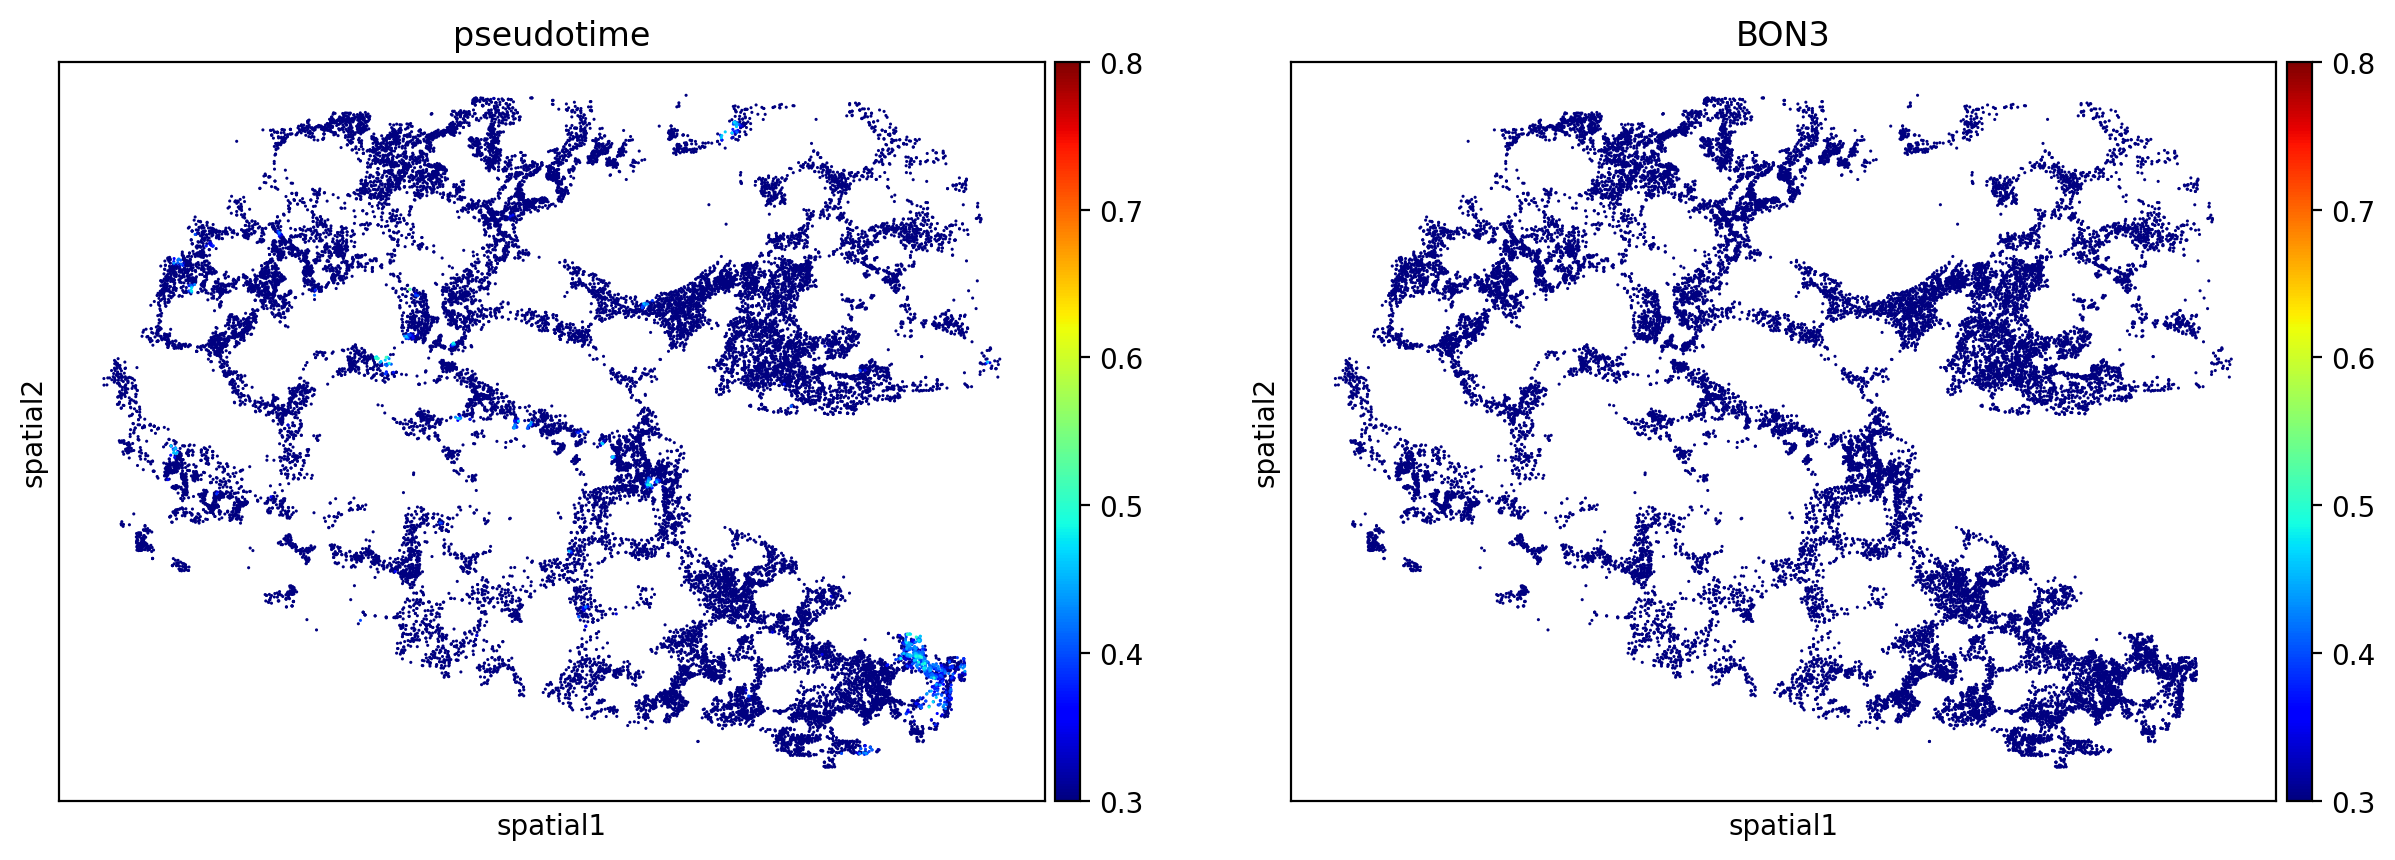

In [24]:
sc.pl.embedding(spatial_data, basis='spatial', color=['pseudotime', 'BON3'], vmin=0.3, vmax=0.8, cmap='jet')

In [25]:
try:
    os.mkdir(os.path.join(data_path, 'integration','dc3000'))
except:
    None
latent_adata.write(os.path.join(data_path, 'integration', 'dc3000', 'latent_adata.h5ad'))
spatial_data.write(os.path.join(data_path, 'integration', 'dc3000', 'spatial_data.h5ad'))
seq_data.write(os.path.join(data_path, 'integration', 'dc3000', 'seq_data.h5ad'))

In [26]:
spatial_data = sc.read(os.path.join(data_path, 'integration', 'dc3000', 'spatial_data.h5ad'))
seq_data = sc.read(os.path.join(data_path, 'integration', 'dc3000', 'seq_data.h5ad'))
latent_adata = sc.read(os.path.join(data_path, 'integration', 'dc3000', 'latent_adata.h5ad'))

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [27]:
seq_data.obs['celltype']= seq_data.obs['celltype'].replace('epidermis', 'Epidermis').replace('mesophyll', 'Mesophyll').replace('undifferentiated', 'Unknown').replace('vasculature', 'Vasculature').replace('', 'Unknown').to_list()

In [28]:
from collections import Counter
# Assuming your original AnnData object is named 'adata'
adata = latent_adata.copy()

# Step 1: Filter spatial and seq cells
spatial_cells = adata[adata.obs['labels'] == 'spatial'].copy()
seq_cells = adata[adata.obs['labels'] == 'seq'].copy()
seq_data_copy = seq_data.copy()

# Step 2: Create KD tree for seq cells
seq_gimvi = seq_data.obsm['X_gimvi']
kdtree = KDTree(seq_gimvi)

# Step 3: Find nearest seq cells for each seq
n_neighbors = 30  # Specify the number of nearest neighbors
distances, indices = kdtree.query(spatial_data.obsm['X_gimvi'], k=n_neighbors)

# Step 4: Average gene expression for spatial cells
averaged_expression = np.zeros((spatial_cells.n_obs, 1))
average_celltype = []

for i in tqdm(range(spatial_cells.n_obs)):
    seq_neighbors_indices = indices[i]

    seq_neighbors_categories = seq_data_copy.obs['SCT_snn_res.1'].values[seq_neighbors_indices]

    # Use Counter to count occurrences
    counter = Counter(seq_neighbors_categories)

    # Find the most common element
    most_common = counter.most_common(1)

    averaged_expression[i] = most_common[0][0]

    seq_neighbors_categories = seq_data_copy.obs['celltype'].values[seq_neighbors_indices]

    # Use Counter to count occurrences
    counter = Counter(seq_neighbors_categories)

    # Find the most common element
    most_common = counter.most_common(1)

    average_celltype.append(most_common[0][0])

spatial_data.obs['DC3000_Cluster_Transfer'] = averaged_expression
spatial_data.obs['celltype'] = average_celltype


  0%|          | 0/24090 [00:00<?, ?it/s]

In [29]:
sc.pp.neighbors(spatial_data, use_rep='X_gimvi')
sc.tl.leiden(spatial_data)

In [30]:
sc.tl.umap(spatial_data, n_components=15)

In [31]:
spatial_data.write(os.path.join(data_path, 'integration', 'dc3000', 'spatial_data.h5ad'))

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


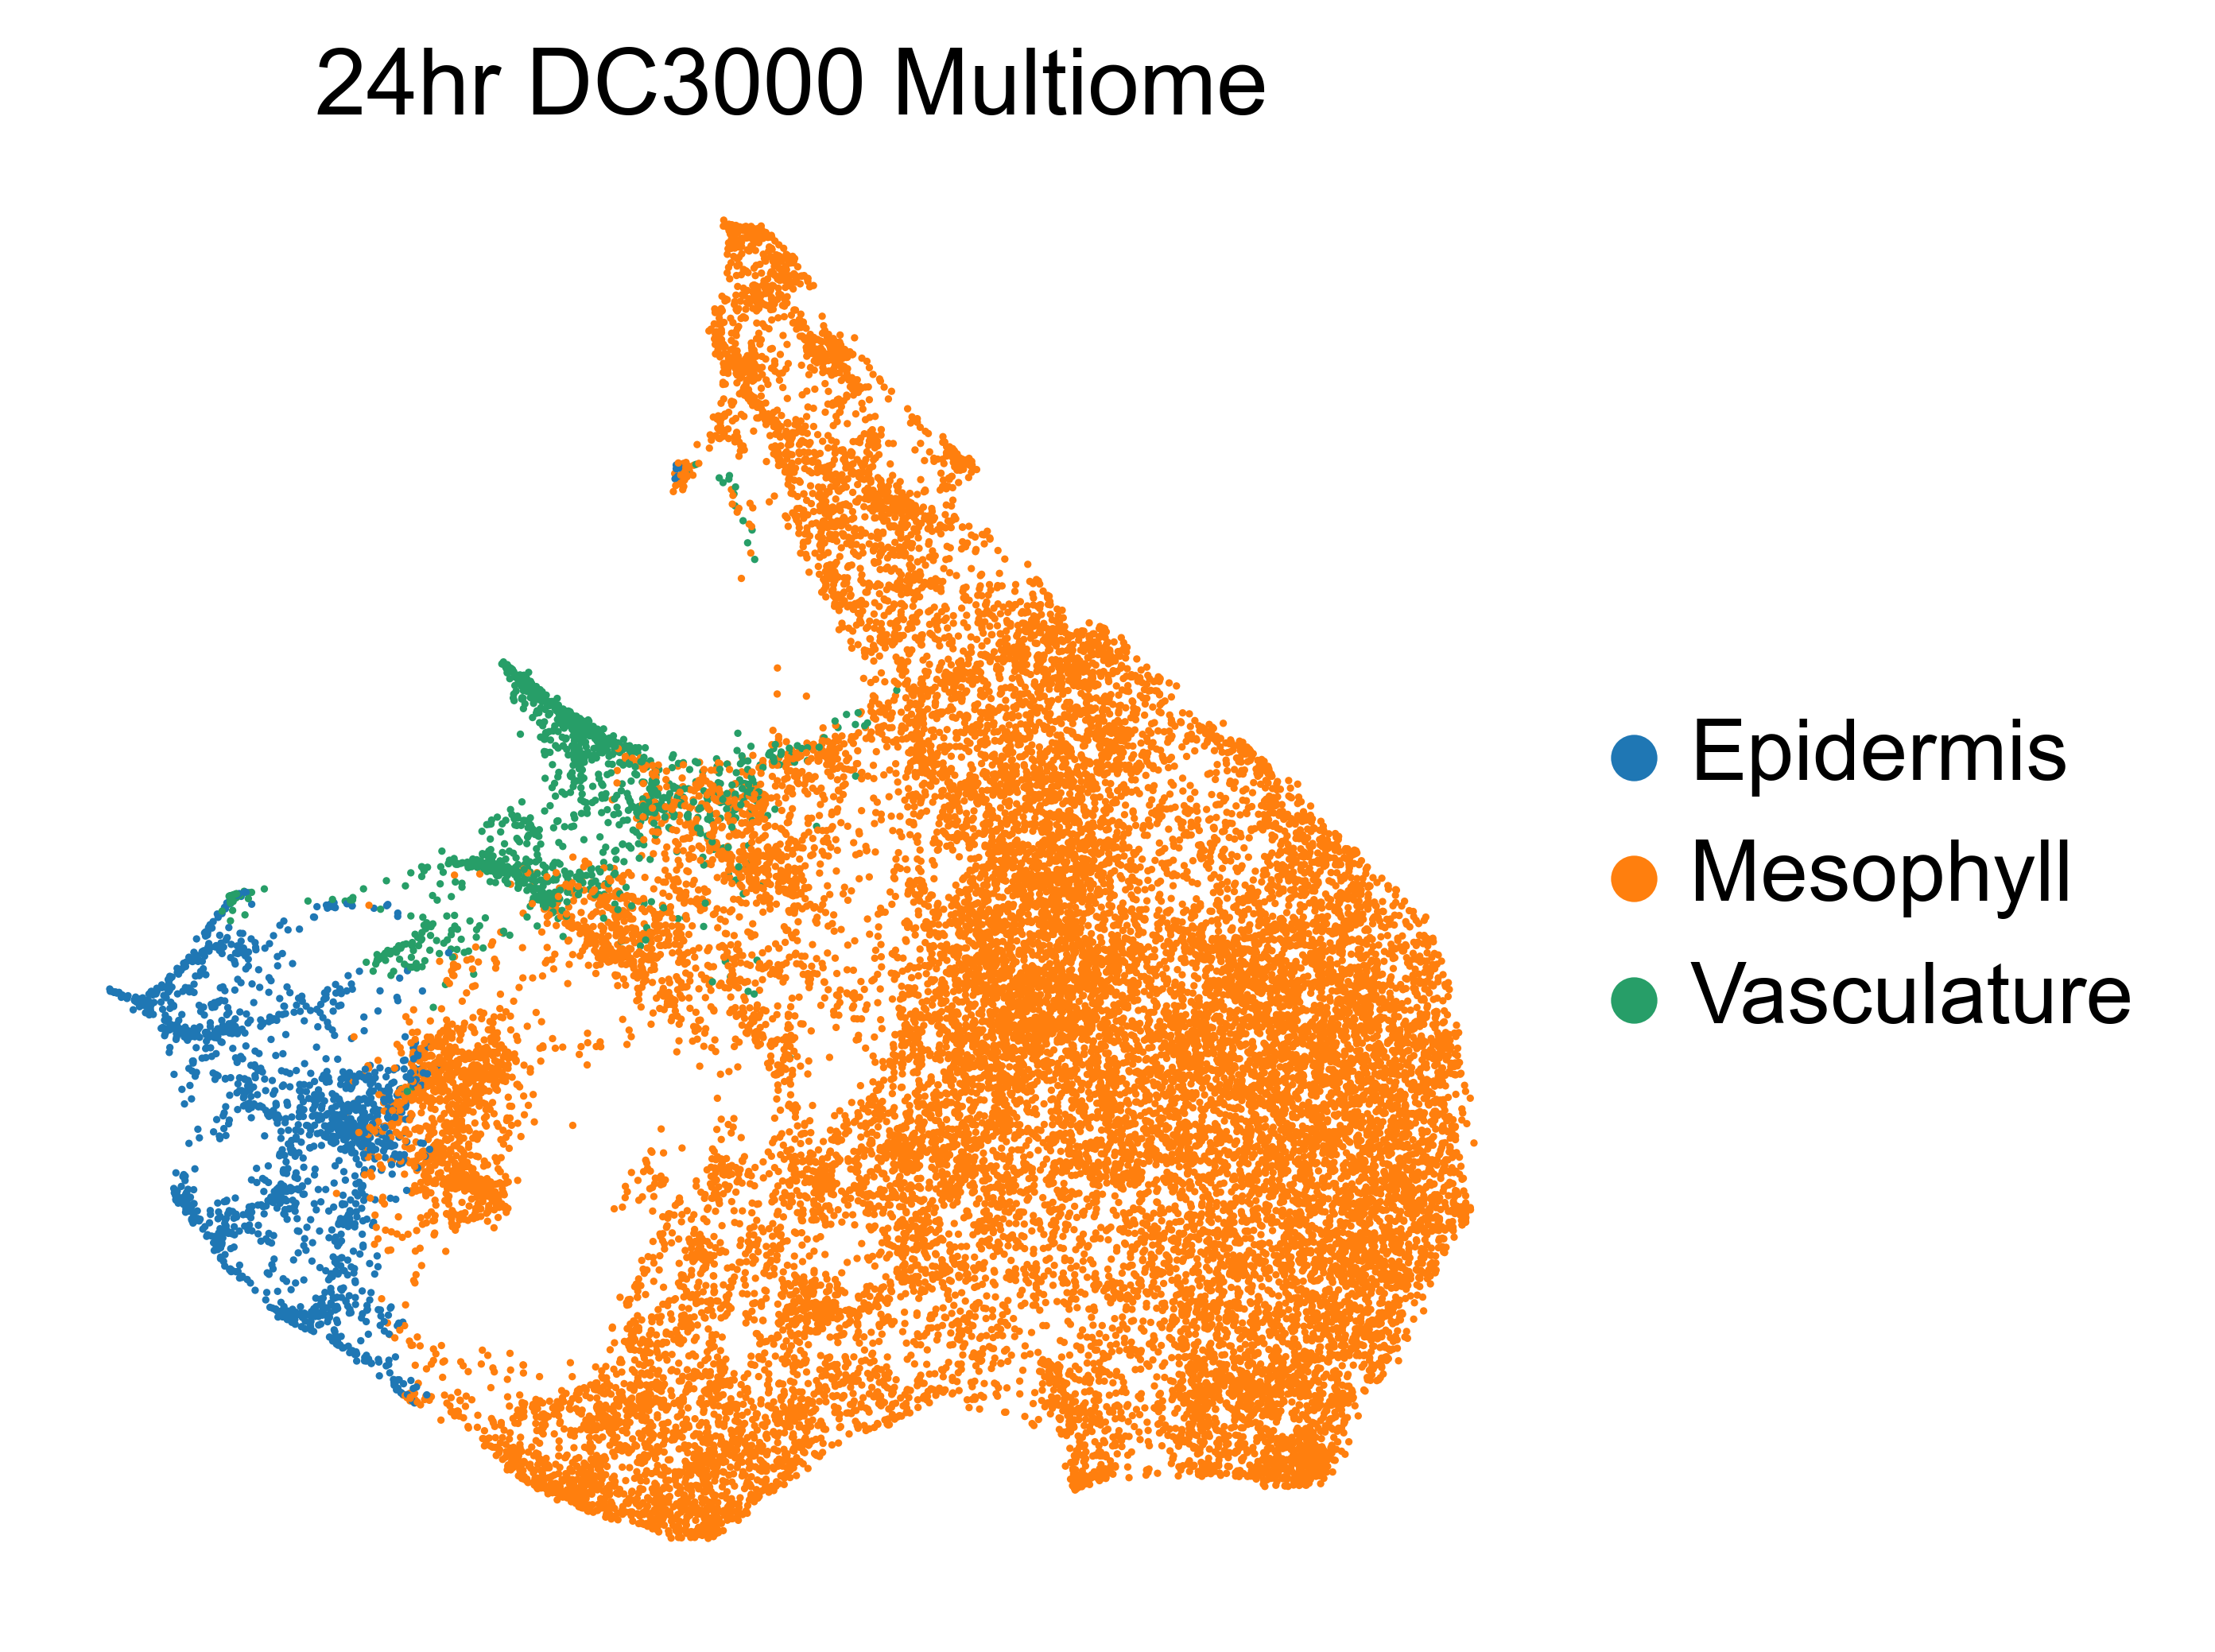

In [32]:
sc.set_figure_params(dpi=300)
fig = sc.pl.embedding(spatial_data, basis='X_umap_gimvi', color='celltype', frameon=False, title = '24hr DC3000 Multiome', return_fig=True, show=False)
plt.axis('equal')

plt.show()